# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Usaremos cuatro modelos para trabajar: un modelo dummy de prueba, de regresión logística con NLTK, de regresión logística con spaCy, y spaCy con LGBMClassifier (descartamos BERT por la premura del tiempo).


# Tabla de contenidos
* [Inicialización](#section1)
* [Cargar datos](#section2)
* [EDA](#section3)
* [Procedimiento de evaluación](#section4)
* [Normalización](#section5)
* [División entrenamiento/prueba](#section6)
* [Trabajar con modelos](#section7)
    * [Modelo 0 - Constante](#section71)
    * [Modelo 1 - NLTK, TF-IDF y LR](#section72)
    * [Modelo 3 - spaCy, TF-IDF y LR](#section73)
    * [Modelo 4 - spaCy, TF-IDF y LGBM](#section74)
* [Mis reseñas](#section8)
    * [Modelo 1](#section81)
    * [Modelo 3](#section82)
    * [Modelo 4](#section83)
* [Conclusiones](#section9)

## Inicialización

In [75]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy

from lightgbm import LGBMClassifier

In [76]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [77]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [78]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

Mostremos un poco de info de nuestro dataset.

In [79]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Parece que casi todos nuestros valores son no nulos, veamos que sucede con los que son nulos. Primero, mostraremos parte de los datos para echar un vistazo.

In [80]:
print("Head")
display(df_reviews.head(n=5))

Head


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Parece que el valor `tconst` no es único, es un indicador único para cada título. Veamos que sucede ahora con las entradas que tienen nulo.

In [81]:
df_reviews.query("average_rating.isnull() | votes.isnull()")

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Parece que todo corresponde a un solo título, busquemos las entradas correspondientes a esta película.

In [82]:
df_reviews.query("tconst == 'tt0192317'")

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Parece que solo son dos esas entradas del mismo título, como realmente no nos impactaría mucho removerlas eso haremos.

In [83]:
df_reviews = df_reviews.dropna()

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

Ahora, resetearemos los índices para continuar.

In [84]:
df_reviews = df_reviews.reset_index(drop=True)

Parece que todo esta mejor.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

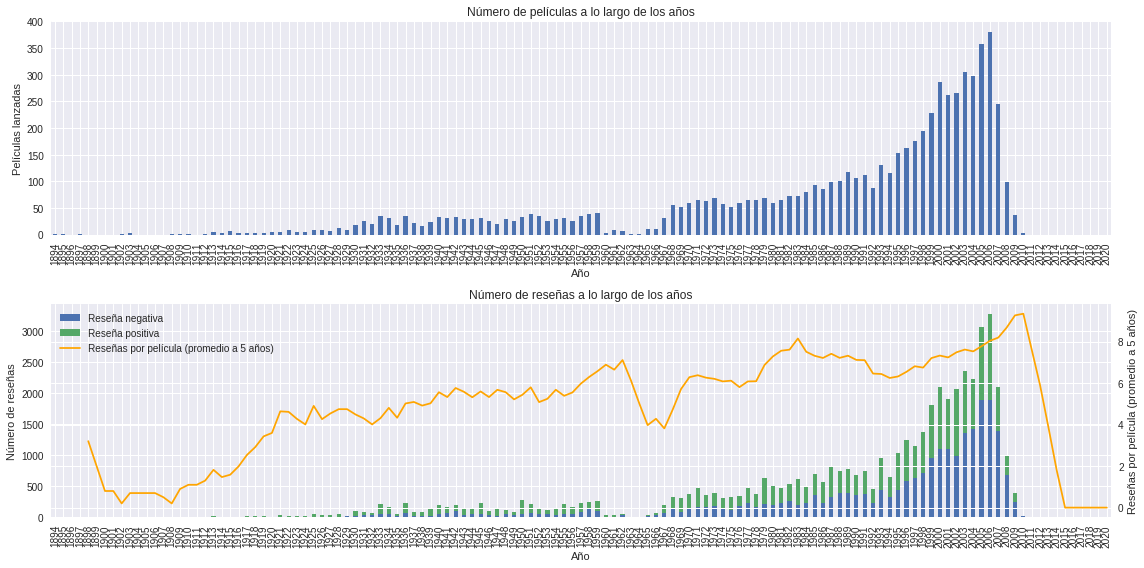

In [85]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)

ax.set_title('Número de películas a lo largo de los años')
ax.set_xlabel("Año")
ax.set_ylabel("Películas lanzadas")

# -----------------------------------------------
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reseñas por película (promedio a 5 años)', ax=axt)

#lines, labels = axt.get_legend_handles_labels()
#axt.legend(lines, labels, loc='upper left')

#ax.legend(["Negativas", "Positivas"], loc='center left')

handles = ax.get_legend_handles_labels()[0] + axt.get_legend_handles_labels()[0]
labels = ["Reseña negativa", "Reseña positiva"] + axt.get_legend_handles_labels()[1]

ax.legend(handles, labels)

ax.set_title('Número de reseñas a lo largo de los años')
ax.set_xlabel("Año")
ax.set_ylabel("Número de reseñas")
axt.set_ylabel("Reseñas por película (promedio a 5 años)")
# -----------------------------------------------
fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

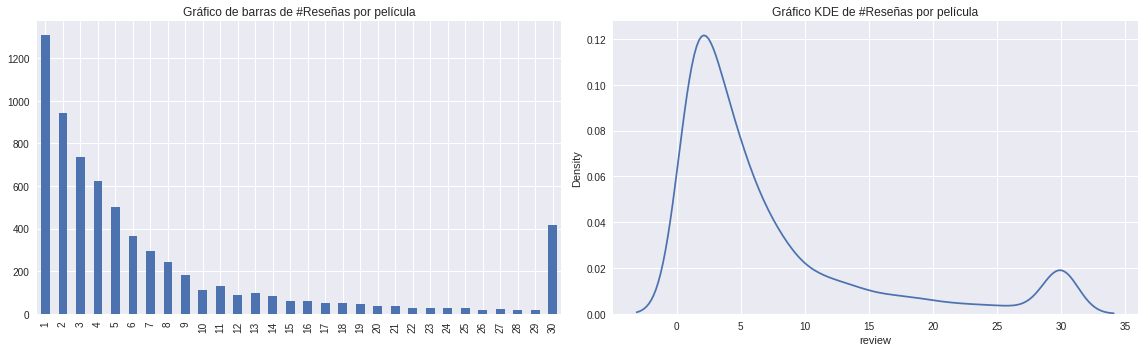

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [87]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

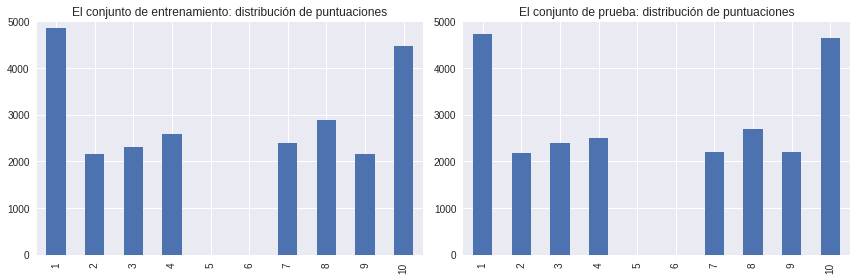

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Parece que tenemos una distribución de puntuaciones similar en los datos de entrenamiento y prueba.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

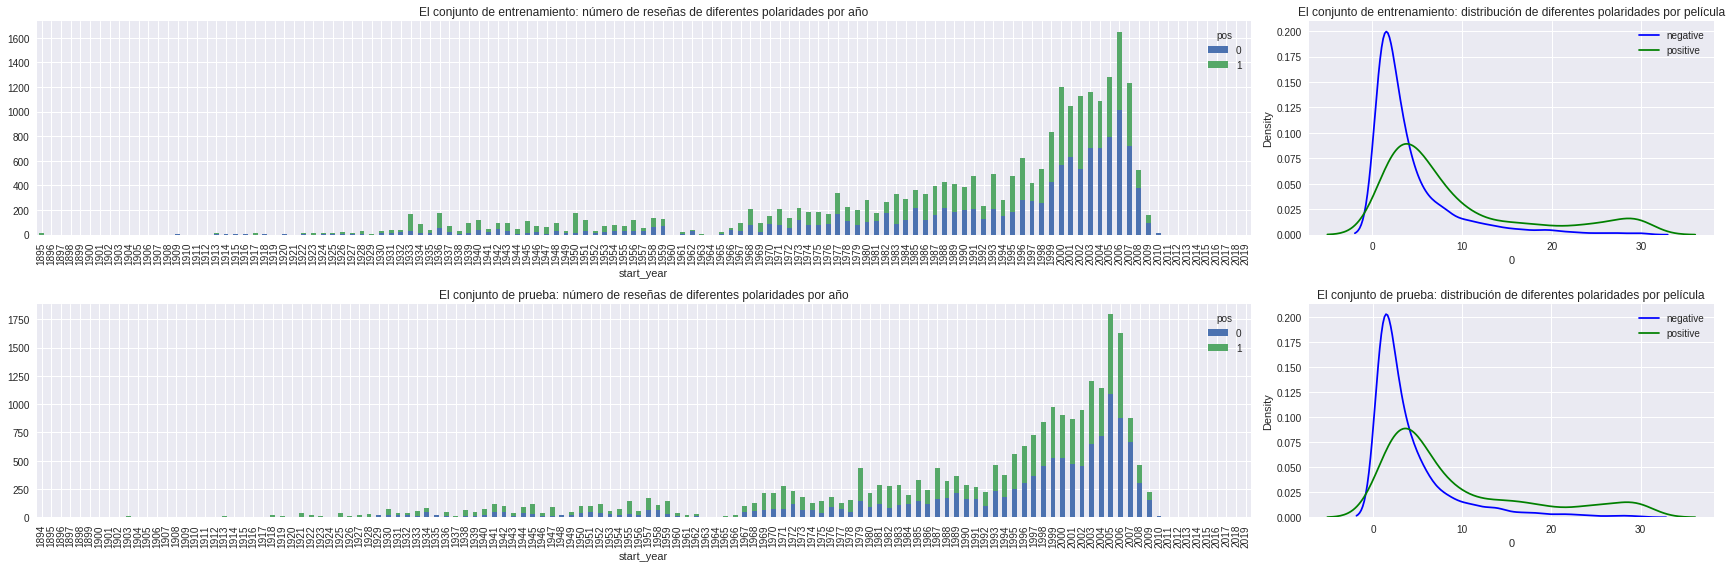

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(24, 8), gridspec_kw=dict(width_ratios=(3, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Otra vez podemos ver que el conjunto de prueba y de entrenamiento tienen un perfil muy similar.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [90]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [91]:
# Usemos lambda para reemplazar, primero quitaremos ' para evitar s sueltas
df_reviews["review_norm"] = df_reviews.review.progress_apply(
    lambda x: re.sub("'s", "", x)
)

df_reviews["review_norm"] = df_reviews.review_norm.progress_apply(
    lambda x: re.sub("[^A-Za-z ]+", "", x)
)

# To lowercase
df_reviews["review_norm"] = df_reviews["review_norm"].str.lower()

# Veamos que tenemos
df_reviews.sample(n=5, random_state=1)

  0%|          | 0/47329 [00:00<?, ?it/s]

  0%|          | 0/47329 [00:00<?, ?it/s]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
33697,tt0408253,movie,Tears of Kali,Tears of Kali,2004,\N,106,0,"Fantasy,Horror",5.3,781,"The plot is real horrific, the atmosphere real...",7,pos,1,train,9773,the plot is real horrific the atmosphere reall...
11889,tt0099512,movie,Ernest Goes to Jail,Ernest Goes to Jail,1990,\N,81,0,"Comedy,Crime,Family",5.4,8690,This was easily one of the weirder of the Erne...,7,pos,1,test,5111,this was easily one of the weirder of the erne...
34863,tt0069811,movie,The Body Shop,The Body Shop,1972,\N,75,0,"Horror,Sci-Fi",3.6,385,My friends and I have watched this so many tim...,1,neg,0,test,9466,my friends and i have watched this so many tim...
1177,tt0318081,movie,A Sound of Thunder,A Sound of Thunder,2005,\N,101,0,"Action,Adventure,Horror",4.2,18578,"This movie reminds me old B movies, but not in...",1,neg,0,test,4111,this movie reminds me old b movies but not in ...
32542,tt0019422,short,Steamboat Willie,Steamboat Willie,1928,\N,8,0,"Animation,Comedy,Family",7.6,7227,A Walt Disney MICKEY MOUSE Cartoon. STEAMBOAT ...,10,pos,1,test,4784,a walt disney mickey mouse cartoon steamboat w...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [92]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


Los dos conjuntos tienen casi la misma dimensión, podemos continuar.

## Trabajar con modelos

### Modelo 0 - Constante

           train  test
Exactitud    0.5   0.5
F1           0.5   0.5
APS          0.5   0.5
ROC AUC      0.5   0.5


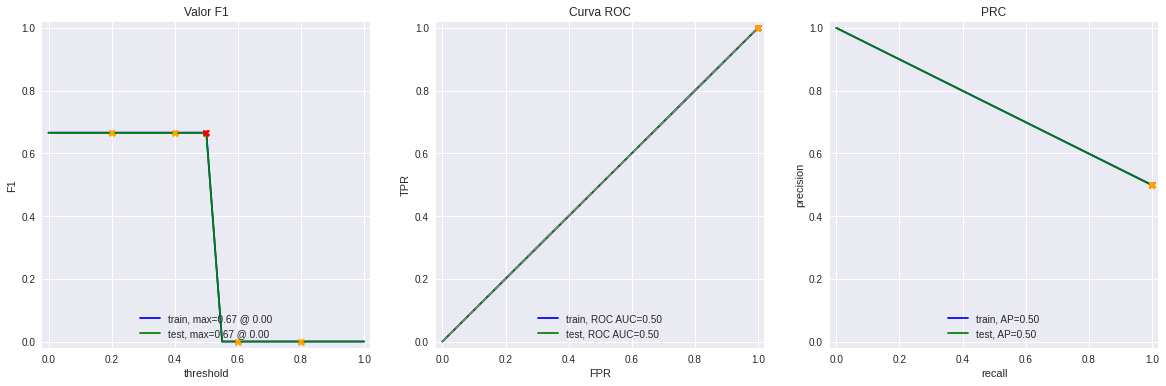

In [93]:
# Preparamos nuestro modelo
model_0 = DummyClassifier(strategy="uniform")
model_0.fit(df_reviews_train.review_norm, train_target)

# Evaluamos
evaluate_model(model_0, df_reviews_train.review_norm, train_target, df_reviews_test.review_norm, test_target)

Podemos ver que el modelo tiene todas las métricas en 0.5, equivalente a tirar una moneda. Tenemos que conseguir mejores valores con nuestros otros modelos.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

Necesitamos lematizar nuestros reviews, usemos el lematizador de NLTK.

In [94]:
# Iniciamos
lemmatizer  = WordNetLemmatizer()

# Definimos la función
def nltk_lematizador(text):
    tokens = word_tokenize(text.lower())
    # Usamos pos para verbos ya que estaba lematizando mal los verbos
    lemmas = [lemmatizer.lemmatize(token, pos="v") for token in tokens] 
    return " ".join(lemmas)

# Lematizamos
corpus_train = df_reviews_train.review_norm.progress_apply(lambda x: nltk_lematizador(x))
corpus_test = df_reviews_test.review_norm.progress_apply(lambda x: nltk_lematizador(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

In [95]:
# Obtenemos las stop_words y vectorizamos
stop_words = set(stopwords.words("english"))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

# features fit
train_features_1 = tfidf_vectorizer_1.fit_transform(corpus_train)
test_features_1 = tfidf_vectorizer_1.transform(corpus_test)

Hemos transformado las features para tener todo en órden, ahora pasamos al modelo.

In [96]:
# Modelo de regresión logística
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


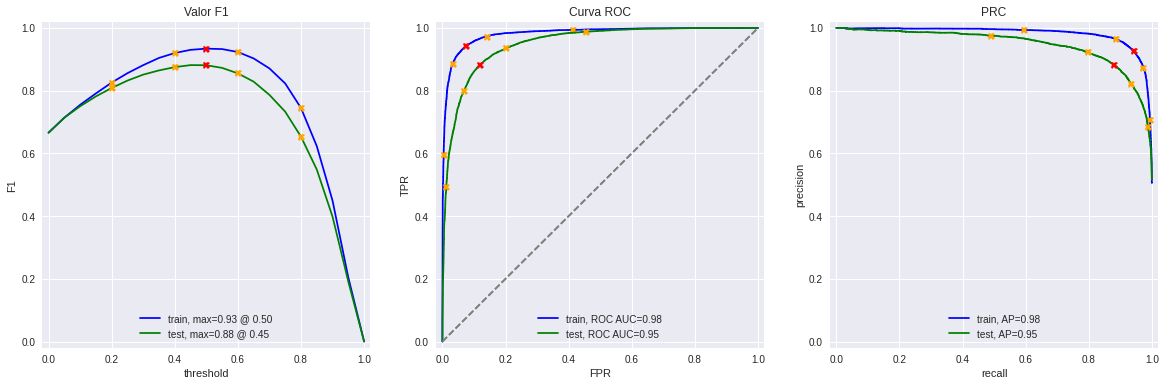

In [97]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Parece que nuestro modelo sencillo tiene mucho mejores métricas que el modelo constante. Todas son mejores a 0.85 por lo que tenemos un buen comienzo.

### Modelo 3 - spaCy, TF-IDF y LR

In [98]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [99]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [100]:
# Hacemos la lematizacion
train_preprocessed = df_reviews_train.review_norm.progress_apply(lambda x: text_preprocessing_3(x))
test_preprocessed = df_reviews_test.review_norm.progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

In [101]:
# Hacemos el mismo proceso que en el modelo anterior

# Obtenemos las stop_words
stop_words = set(stopwords.words("english"))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

# features fit
train_features_3 = tfidf_vectorizer_3.fit_transform(train_preprocessed)
test_features_3 = tfidf_vectorizer_3.transform(test_preprocessed)

Ya tenemos nuestros datos procesados, vamos al modelo

In [102]:
# Modelo de regresión logística
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

LogisticRegression()

Evaluamos el modelo

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


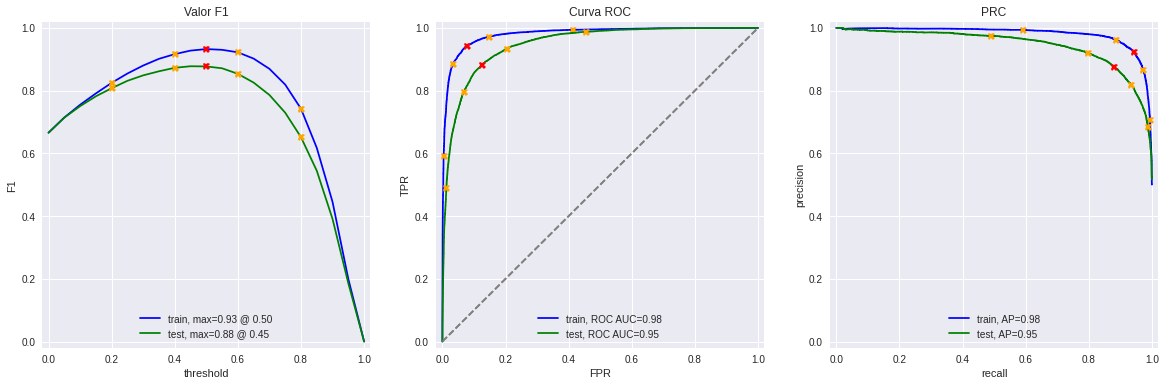

In [103]:
# Evaluamos
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Nuestros resultados no varían realmente en comparación con el modelo anterior, tendremos que buscar nuevas opciones.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

Haremos algo similar al modelo anterior, y usaremos spaCy de nuevo, por lo que no volveremos a lematizar todo (solo le cambiaremos el nombre para que sea más entendible).

In [104]:
# Cambiamos el nombre a los params
train_features_4 = train_features_3
test_features_4 = test_features_3

tfidf_vectorizer_4 = tfidf_vectorizer_3

# Nuestro modelo
model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)

LGBMClassifier()

           train  test
Exactitud   0.91  0.86
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


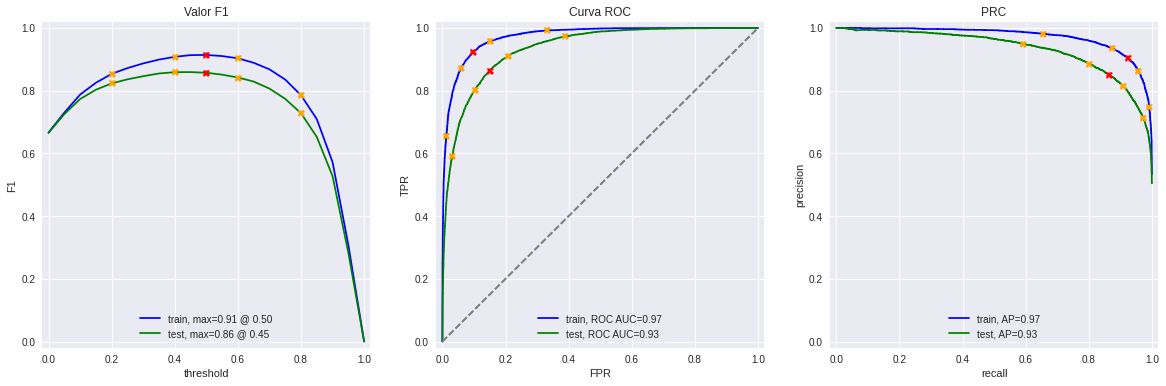

In [105]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

Este modelo es más caro computacionalmente, y ha costado un poco más en ser entrenado pero las métricas son ligeramente peores que las demás: no más complejidad implica mejores resultados.

## Mis reseñas

In [106]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas;
# las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


In [107]:
# Usemos lambda para reemplazar, primero quitaremos ' para evitar s sueltas
my_reviews["review_norm"] = my_reviews.review.progress_apply(
    lambda x: re.sub("'s", "", x)
)

my_reviews["review_norm"] = my_reviews.review_norm.progress_apply(
    lambda x: re.sub("[^A-Za-z ]+", "", x)
)

# To lowercase
my_reviews["review_norm"] = my_reviews.review_norm.str.lower()

# Veamos que tenemos
my_reviews

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 1

In [108]:
# Iniciamos
lemmatizer  = WordNetLemmatizer()

# Lematizamos
texts = my_reviews.review_norm.progress_apply(lambda x: nltk_lematizador(x))

# Calculamos
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]

0.21:  i do not simply like it not my kind of movie
0.06:  well i be bore and felt asleep in the middle of the movie
0.84:  i be really fascinate with the movie
0.14:  even the actors look really old and disinterested and they get pay to be in the movie what a soulles
0.19:  i didnt expect the reboot to be so good writers really care about the source material
0.53:  the movie have its upsides and downsides but i feel like overall it a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoy and loud even kid wont l
0.89:  launch on netflix be a brave move i really appreciate be able to binge on episode after episode of t


Este modelo no captura correctamente las reviews 5 y por poco la 6: esto parece ser debido a que mencione que hay cosas buenas y malas.

### Modelo 3

In [109]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it a decent flick i could see myself
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


Este modelo no detecta apropiadamente la review 3, 5 y 6. Estas últimas dos son las mismas que el modelo anterior, parece que son bastante truculentas para los modelos.

### Modelo 4

In [110]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.38:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.40:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didnt expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall it a decent flick i could see myself
0.22:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


Este modelo logra detectar todas las reviews que los demás fallan, pero no es capaz de elegir bien la primera.

## Conclusiones

Se han analizado los datos y hemos notado que existe un incremento en el número de películas con reseñas, hasta un pico alrededor del 2006 y una caída muy notable (muy cercano al crash financiero del 2008). Nuestros resultados son bastante similares para los tres modelos (exceptuando el modelo dummy): aquí estan las métricas F1 para los tres modelos en sus conjuntos de prueba.

In [112]:
pd.DataFrame(
    {
        "Modelo": ["Modelo 1", "Modelo 3", "Modelo 4"],
        "F1": [0.88, 0.88, 0.86]
    }
)

,Modelo,F1
0,Modelo 1,0.88
1,Modelo 3,0.88
2,Modelo 4,0.86


Las diferencias son mínimas y no podríamos elegir uno definitivamente, embargo cuando hicimos la prueba con nuestras reseñas nos decantamos por el modelo 4: spaCy, TF-IDF y LGBMClassifier, ya que es el que predice mejor de los 4 (y en particular porque predice bien la reseña 5 la cual los demás no son capaces).